## Introduction

Today, (and the rest of the Feat. Eng. module), we are going to participate in the [predict-future-sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales) competition from Kaggle. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms [1C Company](https://1c.ru/eng/title.htm). 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills. This is a good competition for this modeule because it has a lot feature engeniring to make:

- Data Cleaning with Missing & Outliers
- Lot of feature generation
- Extract features from text
- Combine several tables
- Work with the time and exctract lag features
- Etc.

So each day we are going to code our new knowledge from the lecture to this competition. As in any other competition, your goal is to achieve the best possible quality. Good luck!


## Exercise 1: Download the data

Go to the [data tab](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data) of the competition, and download the data. We are going to work on our local computers, but we can work on [kaggle notebooks](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/notebooks) aswell because we have 30 hours of free GPU usage each week.

Please, if you are new to kaggle watch [this video](https://www.youtube.com/watch?v=sEJHyuWKd-s)



## Exercise 2: Basic EDA

The competition data is rather challenging, so the sooner you get yourself familiar with it, the better. You can start with submitting `sample_submission.csv`. You also have to change (from sample_submission) the 0.5 and try submitting different constants. The data of the competition is the following.


- **`sales_train.csv`** Rows: 2935849 sales (January 2013 -> Octuber 2015)
  - **date**: date in format dd/mm/yyyy.
  - **date_block_num**: a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
  - **shop_id**: unique identifier of a shop
  - **item_id**: unique identifier of a product
  - **item_price**: current price of an item
  - **item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure.
- **`shops.csv`** Rows: 60 shops
  - **shop_id**
  - **shop_name**: name of shop (RUSSIAN 🇷🇺)
- **`items.csv`** Rows: 22170 products
  - **item_id**
  - **item_name**: name of item (RUSSIAN 🇷🇺)
  - **item_category_id**: unique identifier of item category
- **`item_categories.csv`** Rows: 84 product categories
  - **item_category_id**
  - **item_category_name**: name of item category (RUSSIAN 🇷🇺)
- **`test.csv`** Rows: 214200 pairs combination of (Shop, Item)
  - **ID**: an Id that represents a (Shop, Item) tuple within the test set
  - **shop_id**
  - **item_id**


## Exercise 3

A good exercise is to reproduce previous month sales. So our predictions for each shop/item pair are just the monthly sales from the previous month (October 2015).

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales dataframe. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. Generating features like this is a necessary basis for more complex models in the next days. Some hints for this exercise:

1. Filter to obtain only the sales from Octuber 2015: `date_block_num==33`
2. Do some aggregation to convert from day detail to month detail: `groupby`
3. Filter the aggregated shop-item pairs to get only the pairs needed at test: `merge`
4. Fill NaNs with zeros: `.fillna(0)`
5. Limit your predictions to the range [0,...,20]: `.clip(lower=0, upper=20)`

If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.


## Submit on Eduflow

When you finish your notebook, push it to your Github repo, copy the link and submit it to the eduflow task.

In [7]:
#!pip install missingno

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import missingno as m
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats

In [2]:
df = pd.read_csv('sales_train.csv')
dftest = pd.read_csv('test.csv')
samplesub = pd.read_csv('sample_submission.csv')

In [3]:
#df = pd.DataFrame((df), columns=['date', 'date_block_num', 'shop_id',  'item_id', 'item_price', 'item_cnt_day'])

In [4]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<AxesSubplot:>

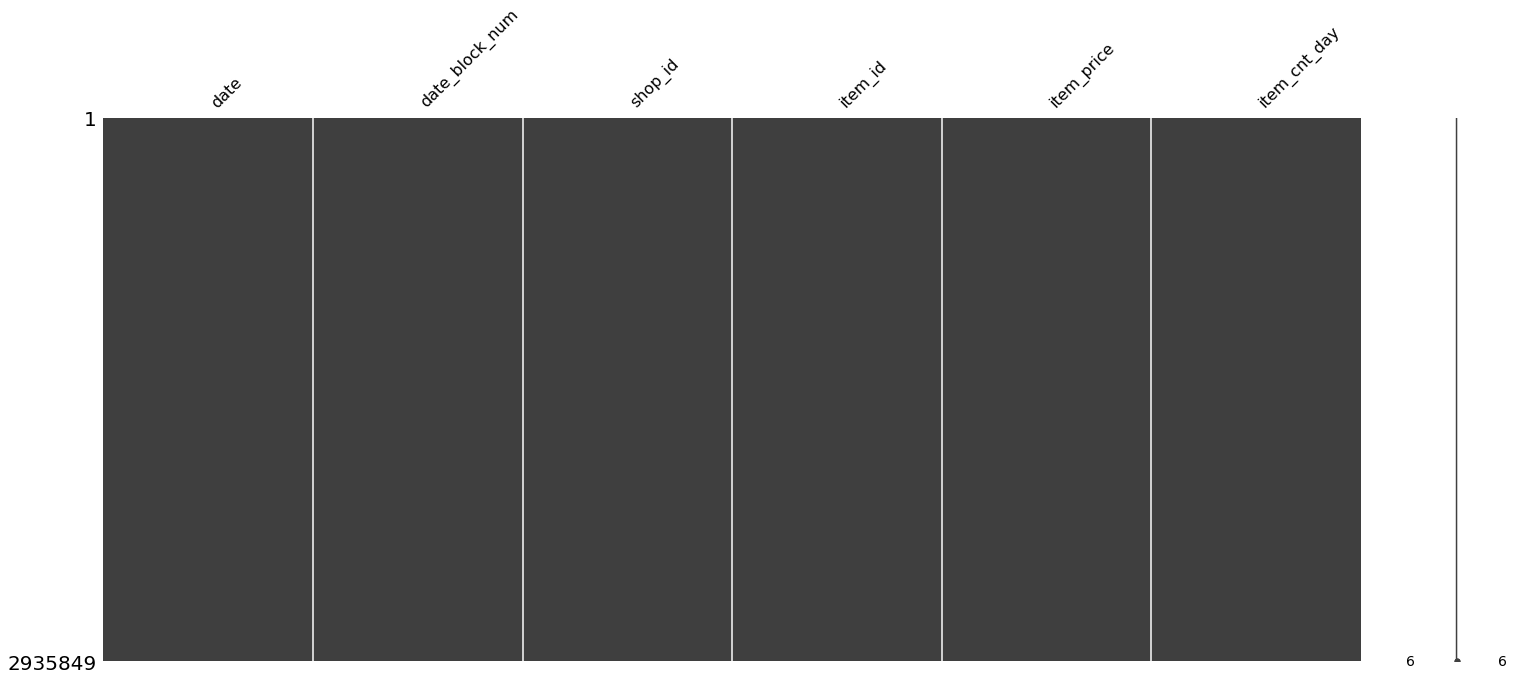

In [6]:
m.matrix(df)

In [9]:
list(df.columns.values)

['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']

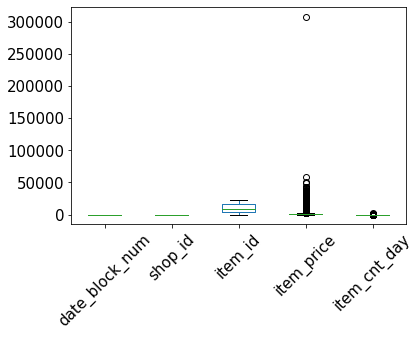

In [10]:
boxplot = df.boxplot(grid=False, rot=45, fontsize=15)

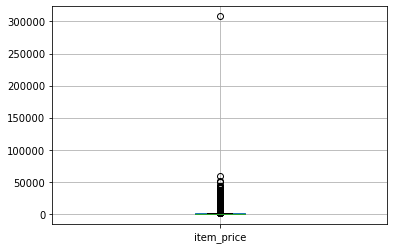

In [50]:
boxplot = df.boxplot(column=['item_price'])

<AxesSubplot:xlabel='item_price'>

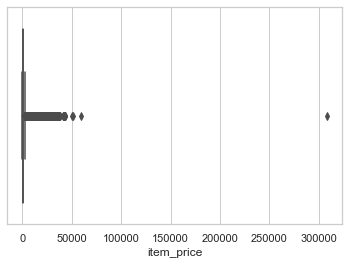

In [83]:
sns.boxplot(x=df['item_price'])

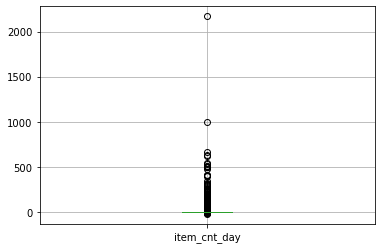

In [49]:
boxplot = df.boxplot(column=['item_cnt_day'])

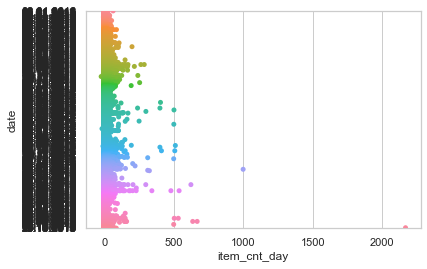

In [58]:
sns.set_theme(style="whitegrid")
ax = sns.stripplot(y=df['date'], x=df['item_cnt_day'], data=df)

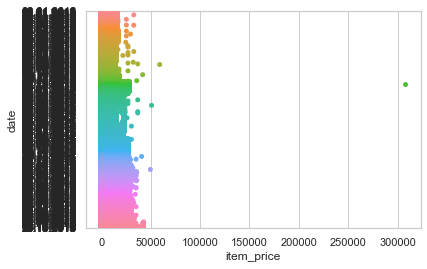

In [59]:
sns.set_theme(style="whitegrid")
ax = sns.stripplot(y=df['date'], x=df['item_price'], data=df)

In [ ]:
#z_scores = stats.zscore(df)

#abs_z_scores = np.abs(z_scores)
#filtered_entries = (abs_z_scores < 3).all(axis=1)
#new_df = df[filtered_entries]

#print(new_df)

In [17]:
df['item_price'].nlargest(2)

1163158    307980.0
885138      59200.0
Name: item_price, dtype: float64

In [18]:
max_price = df.item_price.max()
df_dropped = df.drop(df.loc[df.item_price == max_price].index)
df_dropped = df_dropped.drop(df.loc[df.item_cnt_day > 800].index)


In [19]:
df_dropped

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


<AxesSubplot:xlabel='item_price'>

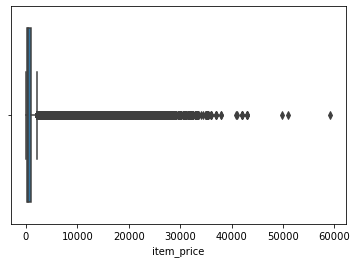

In [20]:
sns.boxplot(x=df_dropped['item_price'])

<AxesSubplot:xlabel='item_cnt_day'>

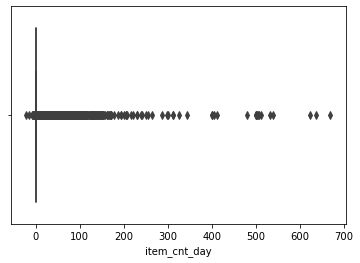

In [21]:
sns.boxplot(x=df_dropped['item_cnt_day'])

In [11]:
#Filter to obtain only the sales from Octuber 2015: date_block_num==33                 X
#Do some aggregation to convert from day detail to month detail: groupby               
#Filter the aggregated shop-item pairs to get only the pairs needed at test: merge
#Fill NaNs with zeros: .fillna(0)
#Limit your predictions to the range [0,...,20]: .clip(lower=0, upper=20)

In [22]:
df_october = df[df.date_block_num ==33]

In [23]:
df_october

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


In [24]:
#Do some aggregation to convert from day detail to month detail: groupby 

df_grouped = df_october.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
df_grouped

,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0
...,...,...,...
31526,59,22087,6.0
31527,59,22088,2.0
31528,59,22091,1.0
31529,59,22100,1.0


In [15]:
#df_grouped = df_grouped.drop(columns=['item_cnt_day'])
#df_grouped['ID'] =  df_grouped.index
#df_grouped

In [16]:
#col_name="ID"
#first_col = df_grouped.pop(col_name)
#df_grouped.insert(0, col_name, first_col)
#df_grouped

In [25]:
dftest

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [70]:
#df_grouped.merge(dftest, how='left', on='shop_id')

In [26]:
results = pd.merge(df_grouped, dftest, on=['shop_id', 'item_id'], how='right')
results

,shop_id,item_id,item_cnt_day,ID
0,5,5037,NaN,0
1,5,5320,NaN,1
2,5,5233,1.0,2
3,5,5232,NaN,3
4,5,5268,NaN,4
...,...,...,...,...
214195,45,18454,1.0,214195
214196,45,16188,NaN,214196
214197,45,15757,NaN,214197
214198,45,19648,NaN,214198


In [28]:
#Filter the aggregated shop-item pairs to get only the pairs needed at test: merge

df_merged = df_grouped.merge(dftest, how='right', on=['shop_id', 'item_id'])

In [29]:
df_merged

,shop_id,item_id,item_cnt_day,ID
0,5,5037,NaN,0
1,5,5320,NaN,1
2,5,5233,1.0,2
3,5,5232,NaN,3
4,5,5268,NaN,4
...,...,...,...,...
214195,45,18454,1.0,214195
214196,45,16188,NaN,214196
214197,45,15757,NaN,214197
214198,45,19648,NaN,214198


In [83]:
df_merged.isnull().sum()

shop_id              0
item_id              0
item_cnt_day    185520
ID                   0
dtype: int64

In [90]:
df_merged = df_merged.replace(np.NaN, 0)
df_merged = df_merged.drop(columns=['ID'])
df_merged

#Fill NaNs with zeros: .fillna(0)
#Limit your predictions to the range [0,...,20]: .clip(lower=0, upper=20)

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0
...,...,...,...
214195,45,18454,1.0
214196,45,16188,0.0
214197,45,15757,0.0
214198,45,19648,0.0


In [92]:
df_merged.item_cnt_day = df_merged.item_cnt_day.clip(lower = 0, upper=20)

In [98]:
sub = df_merged[['item_cnt_day']]

In [99]:
sub.to_csv('last_month_submission.csv', index=False)